# Simple regression with TensorFlow

Progressive example working through various network set ups

https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [31]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(42)


2.13.1


In [32]:
from keras import Sequential
from keras import models
from keras import layers

In [33]:
dat = pd.read_csv("./rbfs/phi_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,854,855,856,857,858,859,860,y,site,date
0,0,1.000000,0.997378,0.989553,0.976648,0.958862,0.936470,0.909811,0.879282,0.845327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,2005,2023-01-01
1,1,1.000000,0.997433,0.989662,0.976809,0.959074,0.936729,0.910113,0.879622,0.845701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007,2005,2023-01-01
2,2,0.999999,0.997487,0.989771,0.976971,0.959285,0.936987,0.910414,0.879962,0.846074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,2005,2023-01-01
3,3,0.999997,0.997541,0.989879,0.977131,0.959496,0.937245,0.910715,0.880302,0.846447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,2005,2023-01-01
4,4,0.999995,0.997594,0.989986,0.977291,0.959707,0.937502,0.911016,0.880641,0.846820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,2005,2023-01-01


In [34]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(191, 865)

In [35]:
dat2 = dat2.groupby('site')

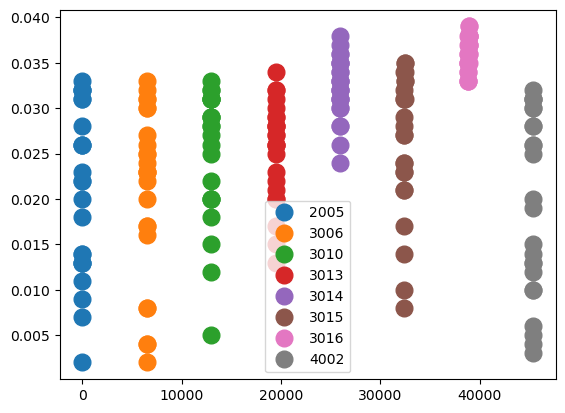

In [36]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [37]:
X = dat.iloc[:, 1:862]
y = dat['y']
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

8

In [45]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [41]:
def make_model(n_feat):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_feat,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')
        ], name="Initial_model")
    return model

In [42]:
model = make_model(100)
model.summary()

Model: "Initial_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 544513 (2.08 MB)
Trainable params: 5445

## Cross-validation loop

In [63]:
# Model set up
initial_learning_rate = 0.00001
optimizer = keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate)
n_epochs = 5
batch_size = 1024

In [64]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [66]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    model = make_model(n_feat)

    # Compile model
    model.compile(loss='mae', metrics=['mae', 'mse'], optimizer=optimizer)

    # Train model
    history=model.fit(X_train, y_train, epochs=n_epochs, 
                  batch_size=batch_size, verbose=1, 
                  validation_split=0.2)
    
    ## Predict for test set
    y_test_pred = model.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test)
    my_y_pred.append(y_test_pred)




Fold 0:
Site 2005:
(45330, 861)
(6491, 861)
Epoch 1/5
36/36 [==============================] - 1s 20ms/step - loss: 0.0411 - mae: 0.0411 - mse: 0.0033 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 5.1547e-04
Epoch 2/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0128 - mae: 0.0128 - mse: 2.6951e-04 - val_loss: 0.0151 - val_mae: 0.0151 - val_mse: 3.5818e-04
Epoch 3/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0103 - mae: 0.0103 - mse: 1.7283e-04 - val_loss: 0.0148 - val_mae: 0.0148 - val_mse: 3.4410e-04
Epoch 4/5
36/36 [==============================] - 1s 18ms/step - loss: 0.0096 - mae: 0.0096 - mse: 1.5232e-04 - val_loss: 0.0146 - val_mae: 0.0146 - val_mse: 3.3655e-04
Epoch 5/5
203/203 [==============================] - 0s 1ms/step
MAE: 0.014440841534971003
Fold 1:
Site 3006:
(45335, 861)
(6486, 861)
Epoch 1/5
36/36 [==============================] - 1s 20ms/step - loss: 0.0226 - mae: 0.0226 - mse: 9.9605e-04 - val_loss: 0.0158 - val_mae: 0.01

In [61]:
my_y_pred

[array([[0.01828379],
        [0.01832085],
        [0.01834937],
        ...,
        [0.04265634],
        [0.04281242],
        [0.04297881]], dtype=float32),
 array([[0.03620334],
        [0.03654896],
        [0.03682848],
        ...,
        [0.04160906],
        [0.04152281],
        [0.04142375]], dtype=float32),
 array([[0.02886784],
        [0.02902658],
        [0.02918759],
        ...,
        [0.04579407],
        [0.04565154],
        [0.04549229]], dtype=float32),
 array([[0.01730682],
        [0.01768254],
        [0.01804266],
        ...,
        [0.03633165],
        [0.03604856],
        [0.03577648]], dtype=float32),
 array([[0.02639223],
        [0.02658941],
        [0.02675371],
        ...,
        [0.0435576 ],
        [0.04340656],
        [0.04325973]], dtype=float32),
 array([[0.02441744],
        [0.02443477],
        [0.02445451],
        ...,
        [0.04196928],
        [0.04206191],
        [0.04214859]], dtype=float32),
 array([[0.02987069],
      

0
1
2
3
4
5
6
7


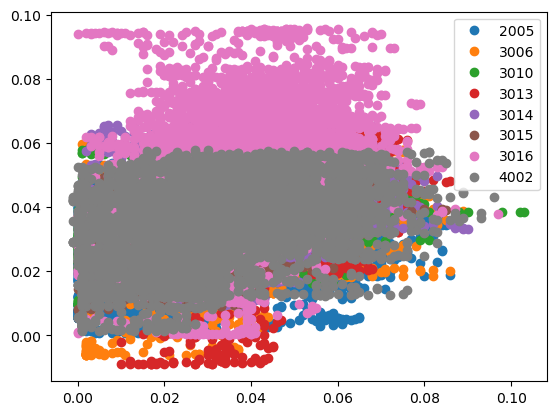

In [80]:
plt.figure()
for i in range(len(mygrps)):
    print(i)
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()